In [1]:
from environments.utils import create_data
import matplotlib.pyplot as plt
import os
from typing import Tuple, List
import torch

In [2]:
sp500_df_train, sp500_df_test = create_data(scale_to_std=False, scale_min_max=True)

C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_gpu\lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
C:\Users\Maciej\anaconda3\envs\pytorch_g

<Axes: xlabel='Date'>

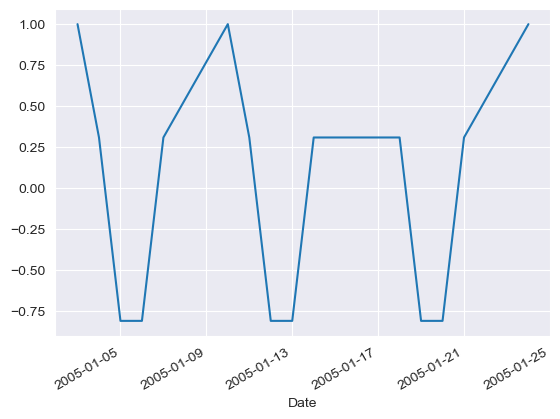

In [12]:
sp500_df_train.iloc[:15]['cos_weekday'].plot()

In [10]:
# check min max and mean of all columns
sp500_df_train.describe()

,open,high,low,close,volume,ADL,ADX,AO,ATR,BBWIDTH,...,WILLIAMS,WMA,WOBV,ZLEMA,sin_weekday,cos_weekday,sin_monthday,cos_monthday,sin_yearday,cos_yearday
count,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,...,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000
mean,0.188727,0.187813,0.189783,0.189684,0.134007,0.223942,0.079002,0.460690,0.086489,0.059180,...,0.621826,0.187080,0.412744,0.187594,0.006045,-0.017376,0.208250,-0.010140,0.223043,0.018977
std,0.106009,0.106388,0.106118,0.106221,0.054961,0.161822,0.049828,0.082733,0.071170,0.051744,...,0.312029,0.106931,0.131066,0.106557,0.712431,0.701698,0.685527,0.697743,0.681269,0.697156
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.951057,-0.809017,-0.997204,-0.988831,-0.999921,-1.000000
25%,0.109119,0.108060,0.109988,0.109846,0.102504,0.057865,0.044061,0.422905,0.040088,0.028280,...,0.356817,0.106590,0.304867,0.107073,-0.587785,-0.809017,-0.433884,-0.733052,-0.391374,-0.675333
50%,0.146718,0.145489,0.147582,0.147616,0.127978,0.227398,0.070910,0.475316,0.066851,0.046783,...,0.697171,0.144622,0.441009,0.145044,0.000000,0.309017,0.433884,0.074730,0.437116,0.037690
75%,0.267065,0.266252,0.268100,0.268248,0.157588,0.360872,0.103604,0.512439,0.104755,0.072895,...,0.908345,0.265839,0.493666,0.266522,0.587785,0.309017,0.866025,0.623490,0.844328,0.711536
max,0.435002,0.433314,0.436032,0.435138,0.483663,0.501664,0.479105,0.723225,0.477068,0.493690,...,1.000000,0.432591,0.718227,0.433736,0.951057,1.000000,0.997204,1.000000,0.999921,1.000000


In [13]:
# save the data
path_to_train_data = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sp_500_train.csv')
sp500_df_train.to_csv(path_to_train_data)
path_to_test_data = os.path.join(os.path.dirname(os.getcwd()), 'data', 'sp_500_test.csv')
sp500_df_test.to_csv(path_to_test_data)

In [14]:
# create window dataloader from sp500_df_tech_indicators_time_enc using pytorch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
# define class for window dataset
class WindowDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.window_size = window_size
    def __len__(self):
        return len(self.data) - self.window_size
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        window = self.data[idx:idx+self.window_size]
        return window

In [15]:
# define class for time series autoencoder
# the data provided to the autoencoder is a window of data so a 2d array
# the autoencoder will encode the data into a 1d array and then decode it back to the original 2d array
# the autoencoder will be trained to minimize the reconstruction error
class TimeSeriesAutoEncoder(torch.nn.Module):
    def __init__(self, matrix_shape: Tuple[int, int], hidden_sizes: List[int]):
        super(TimeSeriesAutoEncoder, self).__init__()
        self.matrix_shape = matrix_shape
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(matrix_shape[0] * matrix_shape[1], hidden_sizes[0]),
        )
        # add batch normalization to the encoder
        self.encoder.add_module('batch_norm', torch.nn.BatchNorm1d(hidden_sizes[0]))
        # iterate through the hidden sizes and create a linear layer for each
        for i in range(1, len(hidden_sizes)):
            self.encoder.add_module(f'linear_{i}', torch.nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))


        self.decoder = torch.nn.Sequential()
        # iterate through the hidden sizes backwards and create a linear layer for each
        for i in range(len(hidden_sizes)-1, 0, -1):
            self.decoder.add_module(f'linear_{i + len(hidden_sizes)}', torch.nn.Linear(hidden_sizes[i], hidden_sizes[i-1]))
        # add the final linear layer to decode the data back to the original shape
        self.decoder.add_module(f'linear_{2 * len(hidden_sizes)}', torch.nn.Linear(hidden_sizes[0], matrix_shape[0] * matrix_shape[1]))
    def forward(self, x):
        # flatten the input
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        # reshape the output
        x = x.view(x.size(0), *self.matrix_shape)
        return x

In [16]:
# define function to train the autoencoder and also evaluate the loss at each epoch
def train_autoencoder(model, train_loader, test_loader, optimizer, criterion, epochs):
    train_losses = []
    test_losses = []
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_loss /= len(train_loader.dataset)
        print(f'====> Epoch: {epoch} Average loss: {train_loss}')
        train_losses.append(train_loss)
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                output = model(data)
                test_loss += criterion(output, data).item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print(f'Test set loss after epoch {epoch}: {test_loss}')
    return train_losses, test_losses

In [17]:
# define function to test the autoencoder
def test_autoencoder(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            output = model(data)
            test_loss += criterion(output, data).item()
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss}')

### Single Layer Autoencoder

In [59]:
# create autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_sizes = [360]
window_size = 5
matrix_shape = (window_size, sp500_df_train.shape[1])
model = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)

In [60]:
# create the train and test datasets
train_dataset = WindowDataset(sp500_df_train, window_size)
test_dataset = WindowDataset(sp500_df_test, window_size)

In [61]:
# create the train and test dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [62]:
# create the optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.MSELoss()

In [63]:
# train the autoencoder
epochs = 30
train_losses, test_losses = train_autoencoder(model, train_loader, test_loader, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.0036455697860464796
Test set loss after epoch 1: 0.0037129267620670293
====> Epoch: 2 Average loss: 0.003294752715667594
Test set loss after epoch 2: 0.005993890392278092
====> Epoch: 3 Average loss: 0.002987688270910368
Test set loss after epoch 3: 0.00571169775235415
====> Epoch: 4 Average loss: 0.002713282164634015
Test set loss after epoch 4: 0.005081650621346518
====> Epoch: 5 Average loss: 0.002472322968430004
Test set loss after epoch 5: 0.004388255151835355
====> Epoch: 6 Average loss: 0.0022617963079129442
Test set loss after epoch 6: 0.003952835820730933
====> Epoch: 7 Average loss: 0.0020761226802347905
Test set loss after epoch 7: 0.003536707645244979
====> Epoch: 8 Average loss: 0.0019168337963008854
Test set loss after epoch 8: 0.003097558596446086
====> Epoch: 9 Average loss: 0.0017754916666818277
Test set loss after epoch 9: 0.0028520173283744015
====> Epoch: 10 Average loss: 0.0016519088183822273
Test set loss after epoch 10: 0.0026336580

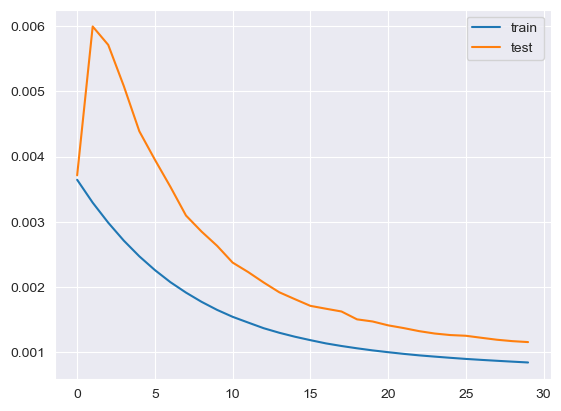

In [64]:
# plot the train and test losses
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.show()

# VALIDATION

====> Epoch: 1 Average loss: 0.003521568441167
Test set loss after epoch 1: 0.0037325549284264676
====> Epoch: 2 Average loss: 0.0031859950239930437
Test set loss after epoch 2: 0.006041407320821893
====> Epoch: 3 Average loss: 0.0028875606614735022
Test set loss after epoch 3: 0.005691568431198729
====> Epoch: 4 Average loss: 0.002622954677105872
Test set loss after epoch 4: 0.005335315896772228
====> Epoch: 5 Average loss: 0.0023943413255886007
Test set loss after epoch 5: 0.004606966895697651
====> Epoch: 6 Average loss: 0.002192353734524746
Test set loss after epoch 6: 0.004132638253816744
====> Epoch: 7 Average loss: 0.0020124993293975132
Test set loss after epoch 7: 0.0036854066962413406
====> Epoch: 8 Average loss: 0.0018615165767039868
Test set loss after epoch 8: 0.003347526963164167
====> Epoch: 9 Average loss: 0.0017207323368427733
Test set loss after epoch 9: 0.0029967382979763056
====> Epoch: 10 Average loss: 0.0016031590786781322
Test set loss after epoch 10: 0.0027470518

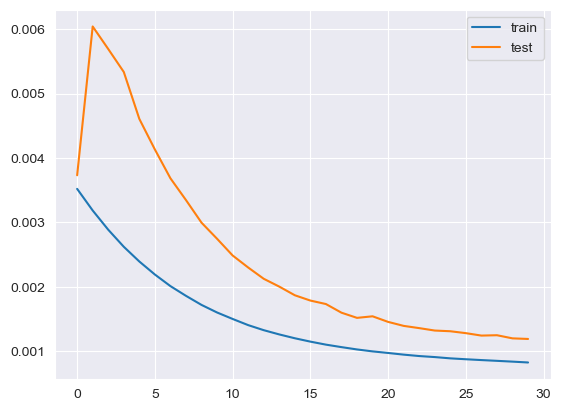

In [71]:
# create autoencoder
# create the train and test datasets
train_dataset = WindowDataset(sp500_df_train, window_size)
test_dataset = WindowDataset(sp500_df_test, window_size)
# create the train and test dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

hidden_sizes = [360]
matrix_shape = (window_size, sp500_df_train.shape[1])
model = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)

# create the optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.MSELoss()
# train the autoencoder
epochs = 30
train_losses, test_losses = train_autoencoder(model, train_loader, test_loader, optimizer, criterion, epochs)
# plot the train and test losses
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.show()

#### Check smaller latent space

In [87]:
# create the optimizer and criterion
# create the train and test datasets
train_dataset = WindowDataset(sp500_df_train, window_size)
test_dataset = WindowDataset(sp500_df_test, window_size)
# create the train and test dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
hidden_sizes = [128]
window_size = 5
matrix_shape = (window_size, sp500_df_train.shape[1])
model_1_layer_smaller_latent = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)
optimizer = torch.optim.Adam(model_1_layer_smaller_latent.parameters(), lr=1e-5)
criterion = torch.nn.MSELoss()
epochs = 400
train_losses_1_layer_smaller_latent, test_losses_1_layer_smaller_latent = train_autoencoder(model_1_layer_smaller_latent, train_loader, test_loader, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.0037291685284485177
Test set loss after epoch 1: 0.0040607532019625745
====> Epoch: 2 Average loss: 0.0035653557112678767
Test set loss after epoch 2: 0.007045430050720925
====> Epoch: 3 Average loss: 0.0034098683157228046
Test set loss after epoch 3: 0.007094181495865274
====> Epoch: 4 Average loss: 0.00326379311779778
Test set loss after epoch 4: 0.006781245018056121
====> Epoch: 5 Average loss: 0.0031239019141206426
Test set loss after epoch 5: 0.006359579954337651
====> Epoch: 6 Average loss: 0.0029923483280557134
Test set loss after epoch 6: 0.00596649868789639
====> Epoch: 7 Average loss: 0.0028671032570778054
Test set loss after epoch 7: 0.005759026219205159
====> Epoch: 8 Average loss: 0.002744516069041197
Test set loss after epoch 8: 0.005461993146101281
====> Epoch: 9 Average loss: 0.002634260709788398
Test set loss after epoch 9: 0.0051655749523983295
====> Epoch: 10 Average loss: 0.0025257011265608447
Test set loss after epoch 10: 0.0049250178

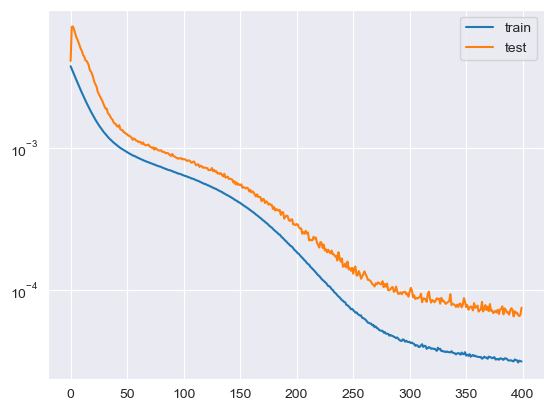

In [88]:
plt.plot(train_losses_1_layer_smaller_latent, label='train')
plt.plot(test_losses_1_layer_smaller_latent, label='test')
plt.legend()
plt.yscale('log')
plt.show()

#### Check larger latent space

In [81]:
# create the optimizer and criterion
hidden_sizes = [256]
window_size = 5
matrix_shape = (window_size, sp500_df_train.shape[1])
model_1_layer_bigger_latent = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)
optimizer = torch.optim.Adam(model_1_layer_bigger_latent.parameters(), lr=1e-5)
criterion = torch.nn.MSELoss()
epochs = 400
train_losses_1_layer_bigger_latent, test_losses_1_layer_bigger_latent = train_autoencoder(model_1_layer_bigger_latent, train_loader, test_loader, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.00373505896282117
Test set loss after epoch 1: 0.0038969958832945897
====> Epoch: 2 Average loss: 0.0034656092652170394
Test set loss after epoch 2: 0.006461760884113692
====> Epoch: 3 Average loss: 0.003222068845319893
Test set loss after epoch 3: 0.00640167523910624
====> Epoch: 4 Average loss: 0.002996876559951879
Test set loss after epoch 4: 0.005773411159240486
====> Epoch: 5 Average loss: 0.0027891963547387482
Test set loss after epoch 5: 0.005450225391832
====> Epoch: 6 Average loss: 0.00260493874912204
Test set loss after epoch 6: 0.005064605543195805
====> Epoch: 7 Average loss: 0.0024313291287217952
Test set loss after epoch 7: 0.004506529831304782
====> Epoch: 8 Average loss: 0.0022775380115345654
Test set loss after epoch 8: 0.004291683171117913
====> Epoch: 9 Average loss: 0.0021361287340468287
Test set loss after epoch 9: 0.003965677119411545
====> Epoch: 10 Average loss: 0.00200910165053634
Test set loss after epoch 10: 0.003542848344388399

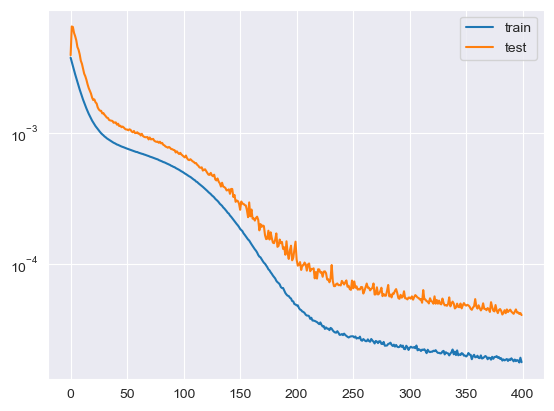

In [85]:
plt.plot(train_losses_1_layer_bigger_latent, label='train')
plt.plot(test_losses_1_layer_bigger_latent, label='test')
plt.legend()
plt.yscale('log')
plt.show()

### Two Layer Autoencoder

In [89]:
# test different autoencoder architectures
# create model with 2 hidden layers
hidden_sizes = [360, 128]
model_2_layers = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)

In [90]:
# train the autoencoder
optimizer = torch.optim.Adam(model_2_layers.parameters(), lr=1e-5)
epochs = 400
train_losses_2_layers, test_losses_2_layers = train_autoencoder(model_2_layers, train_loader, test_loader, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.001385389799141495
Test set loss after epoch 1: 0.0024208217991429264
====> Epoch: 2 Average loss: 0.0012765914844063376
Test set loss after epoch 2: 0.00246848014003686
====> Epoch: 3 Average loss: 0.0011936282915580203
Test set loss after epoch 3: 0.0022926288440063627
====> Epoch: 4 Average loss: 0.0011271187805543127
Test set loss after epoch 4: 0.002128176688487144
====> Epoch: 5 Average loss: 0.0010692339825939823
Test set loss after epoch 5: 0.0019672991761611465
====> Epoch: 6 Average loss: 0.0010187585801339077
Test set loss after epoch 6: 0.0018819879137491704
====> Epoch: 7 Average loss: 0.0009735326974159382
Test set loss after epoch 7: 0.00171878770357225
====> Epoch: 8 Average loss: 0.0009287874934652886
Test set loss after epoch 8: 0.0015962390010214168
====> Epoch: 9 Average loss: 0.0008886530274809906
Test set loss after epoch 9: 0.0014650108346389297
====> Epoch: 10 Average loss: 0.0008477765071388765
Test set loss after epoch 10: 0.0013

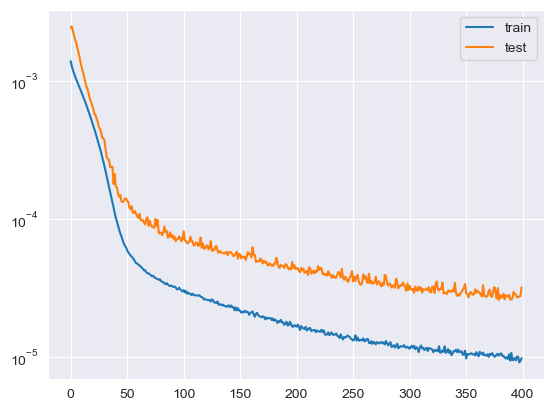

In [91]:
# plot the train and test losses
plt.plot(train_losses_2_layers, label='train')
plt.plot(test_losses_2_layers, label='test')
plt.legend()
plt.yscale('log')
plt.show()

#### 2 layers with smaller latent space

In [96]:
hidden_sizes = [256, 64]
model_2_layers_smaller_latent = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)
optimizer = torch.optim.Adam(model_2_layers_smaller_latent.parameters(), lr=1e-5)
epochs = 1600
train_losses_2_layers_smaller_latent, test_losses_2_layers_smaller_latent = train_autoencoder(model_2_layers_smaller_latent, train_loader, test_loader, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.0014252115404385169
Test set loss after epoch 1: 0.0025100064383377784
====> Epoch: 2 Average loss: 0.0013412701207387839
Test set loss after epoch 2: 0.002608446020244759
====> Epoch: 3 Average loss: 0.0012707588347521696
Test set loss after epoch 3: 0.00243667250461959
====> Epoch: 4 Average loss: 0.0012149274489206977
Test set loss after epoch 4: 0.0023268905949433995
====> Epoch: 5 Average loss: 0.0011654570101703454
Test set loss after epoch 5: 0.0022084393647980533
====> Epoch: 6 Average loss: 0.0011219224751275625
Test set loss after epoch 6: 0.00212180241116399
====> Epoch: 7 Average loss: 0.0010802108474316666
Test set loss after epoch 7: 0.002026506230862865
====> Epoch: 8 Average loss: 0.001044525833593017
Test set loss after epoch 8: 0.0019755414015966612
====> Epoch: 9 Average loss: 0.0010092578834511028
Test set loss after epoch 9: 0.0018701585063384536
====> Epoch: 10 Average loss: 0.0009778528647977497
Test set loss after epoch 10: 0.00178

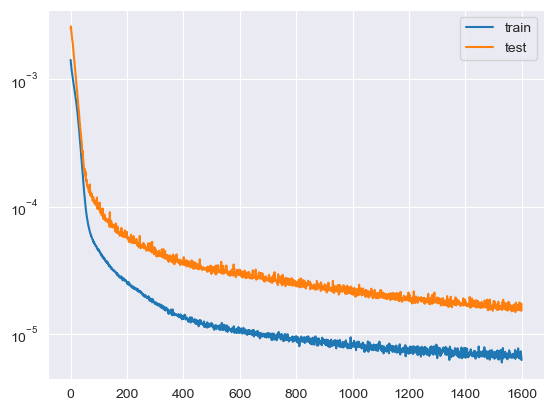

In [97]:
# plot results
plt.plot(train_losses_2_layers_smaller_latent, label='train')
plt.plot(test_losses_2_layers_smaller_latent, label='test')
plt.legend()
plt.yscale('log')
plt.show()

#### 2 layers with even smaller latent space

In [101]:
hidden_sizes = [128, 32]
model_2_layers_smallest_latent = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)
optimizer = torch.optim.Adam(model_2_layers_smallest_latent.parameters(), lr=1e-5)
epochs = 1600
train_losses_2_layers_smallest_latent, test_losses_2_layers_smallest_latent = train_autoencoder(model_2_layers_smallest_latent, train_loader, test_loader, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.0014026474107790797
Test set loss after epoch 1: 0.0024783892139891564
====> Epoch: 2 Average loss: 0.00134772523871177
Test set loss after epoch 2: 0.002694501316468097
====> Epoch: 3 Average loss: 0.001301050054397857
Test set loss after epoch 3: 0.0025528110646355706
====> Epoch: 4 Average loss: 0.0012574132576144246
Test set loss after epoch 4: 0.0025365668165181535
====> Epoch: 5 Average loss: 0.0012228081950366612
Test set loss after epoch 5: 0.0024166745185323405
====> Epoch: 6 Average loss: 0.0011891669398943145
Test set loss after epoch 6: 0.0023186851433269727
====> Epoch: 7 Average loss: 0.0011573171674892303
Test set loss after epoch 7: 0.0022762545824315224
====> Epoch: 8 Average loss: 0.0011302260329427557
Test set loss after epoch 8: 0.00223473561907026
====> Epoch: 9 Average loss: 0.0011038685551530323
Test set loss after epoch 9: 0.0021753250032729428
====> Epoch: 10 Average loss: 0.0010771193052892957
Test set loss after epoch 10: 0.0021

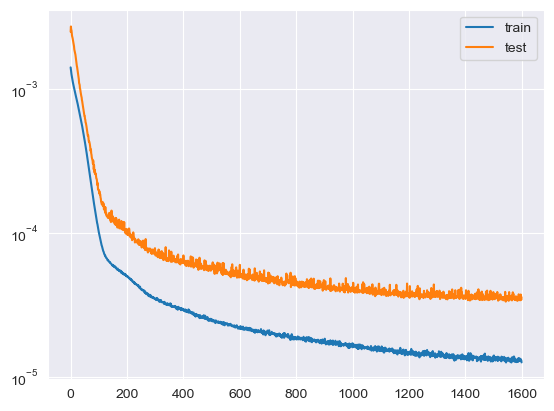

In [102]:
# plot results
plt.plot(train_losses_2_layers_smallest_latent, label='train')
plt.plot(test_losses_2_layers_smallest_latent, label='test')
plt.legend()
plt.yscale('log')
plt.show()

### 3 layers

In [103]:
hidden_sizes = [360, 128, 64]
model_3_layers = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)
optimizer = torch.optim.Adam(model_3_layers.parameters(), lr=1e-5)
epochs = 1600
train_losses_3_layers, test_losses_3_layers = train_autoencoder(model_3_layers, train_loader, test_loader, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.001128310741690451
Test set loss after epoch 1: 0.0021914421950369875
====> Epoch: 2 Average loss: 0.0010811650981953145
Test set loss after epoch 2: 0.0021103581541657714
====> Epoch: 3 Average loss: 0.001039797179225928
Test set loss after epoch 3: 0.0020196620713580737
====> Epoch: 4 Average loss: 0.0009948468135845335
Test set loss after epoch 4: 0.0018576579354290424
====> Epoch: 5 Average loss: 0.0009519560404099229
Test set loss after epoch 5: 0.0017049112863128308
====> Epoch: 6 Average loss: 0.0009055129152267933
Test set loss after epoch 6: 0.0015367689457806673
====> Epoch: 7 Average loss: 0.0008586392910087197
Test set loss after epoch 7: 0.001395660979123972
====> Epoch: 8 Average loss: 0.0008107817454639803
Test set loss after epoch 8: 0.001264827842194331
====> Epoch: 9 Average loss: 0.0007596566478466257
Test set loss after epoch 9: 0.0011313163454411035
====> Epoch: 10 Average loss: 0.0007076728538308693
Test set loss after epoch 10: 0.00

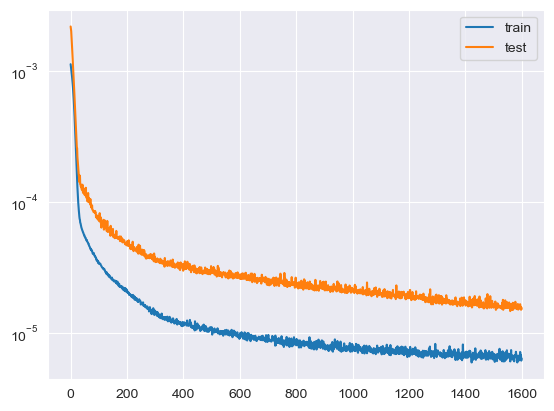

In [104]:
# plot results
plt.plot(train_losses_3_layers, label='train')
plt.plot(test_losses_3_layers, label='test')
plt.legend()
plt.yscale('log')
plt.show()

## Compare the different models

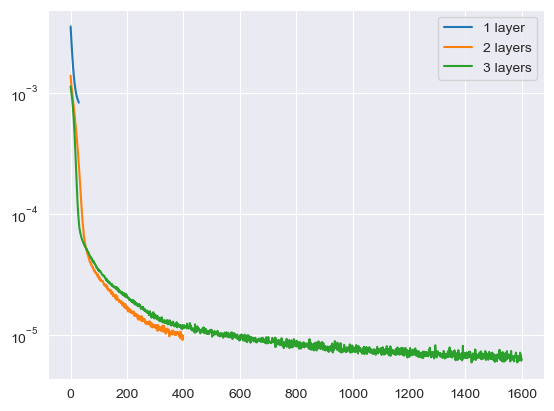

In [106]:
# plot the train and test losses
plt.plot(train_losses, label='1 layer')
plt.plot(train_losses_2_layers, label='2 layers')
plt.plot(train_losses_3_layers, label='3 layers')
plt.yscale('log')
plt.legend()

## Learning autoencoder with greater window size
### 1 layer

In [109]:
window_size = 60
matrix_shape = (window_size, sp500_df_train.shape[1])
hidden_sizes = [512]
model_60_1_layer = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)
optimizer = torch.optim.Adam(model_60_1_layer.parameters(), lr=1e-5)
train_dataset_60 = WindowDataset(sp500_df_train, window_size)
test_dataset_60 = WindowDataset(sp500_df_test, window_size)
train_loader_60 = DataLoader(train_dataset_60, batch_size=batch_size, shuffle=False)
test_loader_60 = DataLoader(test_dataset_60, batch_size=batch_size, shuffle=False)
epochs = 1600
train_losses_60_1_layer, test_losses_60_1_layer = train_autoencoder(model_60_1_layer, train_loader_60, test_loader_60, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.0034931765662299264
Test set loss after epoch 1: 0.0033852218737146227
====> Epoch: 2 Average loss: 0.0030945316124310262
Test set loss after epoch 2: 0.006410187926174195
====> Epoch: 3 Average loss: 0.002761949510151556
Test set loss after epoch 3: 0.006603003322304069
====> Epoch: 4 Average loss: 0.002472993893722359
Test set loss after epoch 4: 0.006008155969408073
====> Epoch: 5 Average loss: 0.002216592903523868
Test set loss after epoch 5: 0.0053941630346012225
====> Epoch: 6 Average loss: 0.001989428380422721
Test set loss after epoch 6: 0.004832010588651564
====> Epoch: 7 Average loss: 0.0017920142179720865
Test set loss after epoch 7: 0.004346439449958846
====> Epoch: 8 Average loss: 0.001625353694129338
Test set loss after epoch 8: 0.003945961682545956
====> Epoch: 9 Average loss: 0.0014888500098628227
Test set loss after epoch 9: 0.0036260828006366066
====> Epoch: 10 Average loss: 0.0013798062724095803
Test set loss after epoch 10: 0.003374773

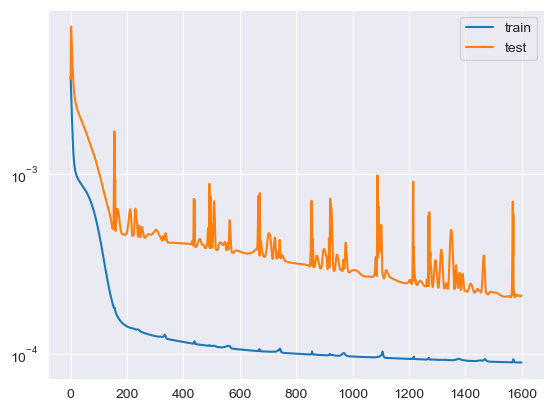

In [110]:
# plot results
plt.plot(train_losses_60_1_layer, label='train')
plt.plot(test_losses_60_1_layer, label='test')
plt.legend()
plt.yscale('log')
plt.show()

### 2 layers

In [112]:
hidden_sizes = [2048, 512]
model_60_2_layers = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)
optimizer = torch.optim.Adam(model_60_2_layers.parameters(), lr=1e-5)
# increase batch size
batch_size = 256
train_dataset_60 = WindowDataset(sp500_df_train, window_size)
test_dataset_60 = WindowDataset(sp500_df_test, window_size)
train_loader_60 = DataLoader(train_dataset_60, batch_size=batch_size, shuffle=False)
test_loader_60 = DataLoader(test_dataset_60, batch_size=batch_size, shuffle=False)
epochs = 1600
train_losses_60_2_layers, test_losses_60_2_layers = train_autoencoder(model_60_2_layers, train_loader_60, test_loader_60, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.0006530586249633002
Test set loss after epoch 1: 0.0012481525417201776
====> Epoch: 2 Average loss: 0.0005852050000569635
Test set loss after epoch 2: 0.0012390648037934105
====> Epoch: 3 Average loss: 0.0005488714493819492
Test set loss after epoch 3: 0.0012256782479944872
====> Epoch: 4 Average loss: 0.0005224395384458045
Test set loss after epoch 4: 0.001179175471189875
====> Epoch: 5 Average loss: 0.000498439805157792
Test set loss after epoch 5: 0.0010986537128299862
====> Epoch: 6 Average loss: 0.00047380947554954376
Test set loss after epoch 6: 0.0010090588889972096
====> Epoch: 7 Average loss: 0.00044736089278953246
Test set loss after epoch 7: 0.0009254571996022284
====> Epoch: 8 Average loss: 0.0004194744943100729
Test set loss after epoch 8: 0.000853659710467495
====> Epoch: 9 Average loss: 0.000392061625800684
Test set loss after epoch 9: 0.0007929778366471688
====> Epoch: 10 Average loss: 0.0003673080250403429
Test set loss after epoch 10: 0.

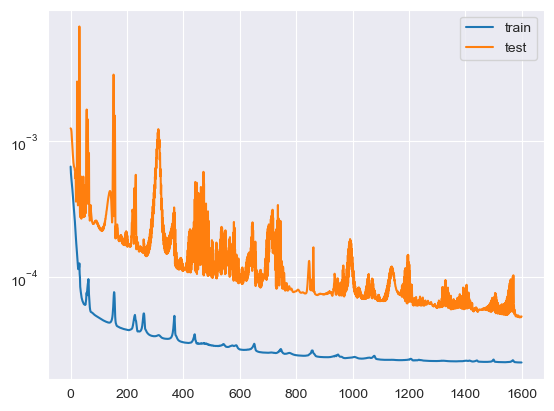

In [113]:
# plot results
plt.plot(train_losses_60_2_layers, label='train')
plt.plot(test_losses_60_2_layers, label='test')
plt.legend()
plt.yscale('log')
plt.show()

#### 3 layers

In [116]:
hidden_sizes = [2048, 1024, 512]
model_60_3_layers = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)
optimizer = torch.optim.Adam(model_60_3_layers.parameters(), lr=5e-5)
epochs = 1600
train_losses_60_3_layers, test_losses_60_3_layers = train_autoencoder(model_60_3_layers, train_loader_60, test_loader_60, optimizer, criterion, epochs)

====> Epoch: 1 Average loss: 0.0005053778092233688
Test set loss after epoch 1: 0.0009710868246580662
====> Epoch: 2 Average loss: 0.00034440899796691943
Test set loss after epoch 2: 0.0009437988577091708
====> Epoch: 3 Average loss: 0.0001784961902683833
Test set loss after epoch 3: 0.002014333234908589
====> Epoch: 4 Average loss: 0.00014937218429163248
Test set loss after epoch 4: 0.001049061751140473
====> Epoch: 5 Average loss: 0.000110075643388544
Test set loss after epoch 5: 0.002515471213823789
====> Epoch: 6 Average loss: 8.965771609768856e-05
Test set loss after epoch 6: 0.0006298983058372101
====> Epoch: 7 Average loss: 7.693403307453015e-05
Test set loss after epoch 7: 0.0003332503474237224
====> Epoch: 8 Average loss: 7.294744643038839e-05
Test set loss after epoch 8: 0.0003158857797436337
====> Epoch: 9 Average loss: 6.989510933733749e-05
Test set loss after epoch 9: 0.000307514106826208
====> Epoch: 10 Average loss: 6.722824806901475e-05
Test set loss after epoch 10: 0.0

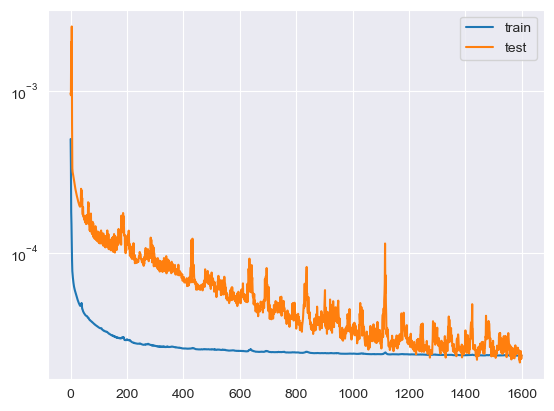

In [123]:
# plot results
plt.plot(train_losses_60_3_layers, label='train')
plt.plot(test_losses_60_3_layers, label='test')
plt.legend()
plt.yscale('log')
plt.show()

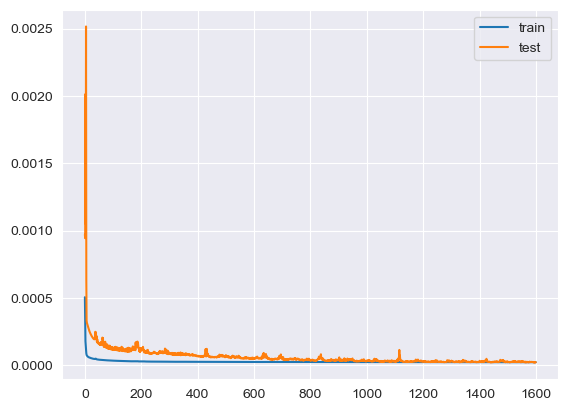

In [15]:
# try to lean the autoencoder on the cropped data and see if it can learn the pattern
# create the train and test datasets
cropped_train_df = sp500_df_train
cropped_test_df = sp500_df_test

window_size = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset_cropped = WindowDataset(cropped_train_df, window_size)
test_dataset_cropped = WindowDataset(cropped_test_df, window_size)

# create the train and test dataloaders
batch_size = 128
train_loader_cropped = DataLoader(train_dataset_cropped, batch_size=batch_size, shuffle=True)
test_loader_cropped = DataLoader(test_dataset_cropped, batch_size=batch_size, shuffle=True)

# move the dataloaders to the GPU

# create the optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# let the loss be mae
criterion = torch.nn.L1Loss()

# define new model
hidden_sizes = [1]


matrix_shape = (window_size, cropped_train_df.shape[1])
model_cropped = TimeSeriesAutoEncoder(matrix_shape, hidden_sizes).to(device)


# train the autoencoder
epochs = 30
train_losses, test_losses = train_autoencoder(model_cropped, train_loader_cropped, test_loader_cropped, optimizer, criterion, epochs)

# plot the train and test losses
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

====> Epoch: 1 Average loss: nan
Test set loss after epoch 1: nan
====> Epoch: 2 Average loss: nan
Test set loss after epoch 2: nan
====> Epoch: 3 Average loss: nan
Test set loss after epoch 3: nan
====> Epoch: 4 Average loss: nan
Test set loss after epoch 4: nan
====> Epoch: 5 Average loss: nan
Test set loss after epoch 5: nan
====> Epoch: 6 Average loss: nan
Test set loss after epoch 6: nan
====> Epoch: 7 Average loss: nan
Test set loss after epoch 7: nan
====> Epoch: 8 Average loss: nan
Test set loss after epoch 8: nan
====> Epoch: 9 Average loss: nan
Test set loss after epoch 9: nan
====> Epoch: 10 Average loss: nan
Test set loss after epoch 10: nan
====> Epoch: 11 Average loss: nan
Test set loss after epoch 11: nan
====> Epoch: 12 Average loss: nan
Test set loss after epoch 12: nan
====> Epoch: 13 Average loss: nan
Test set loss after epoch 13: nan
====> Epoch: 14 Average loss: nan



KeyboardInterrupt



Loss: 0.5675565600395203


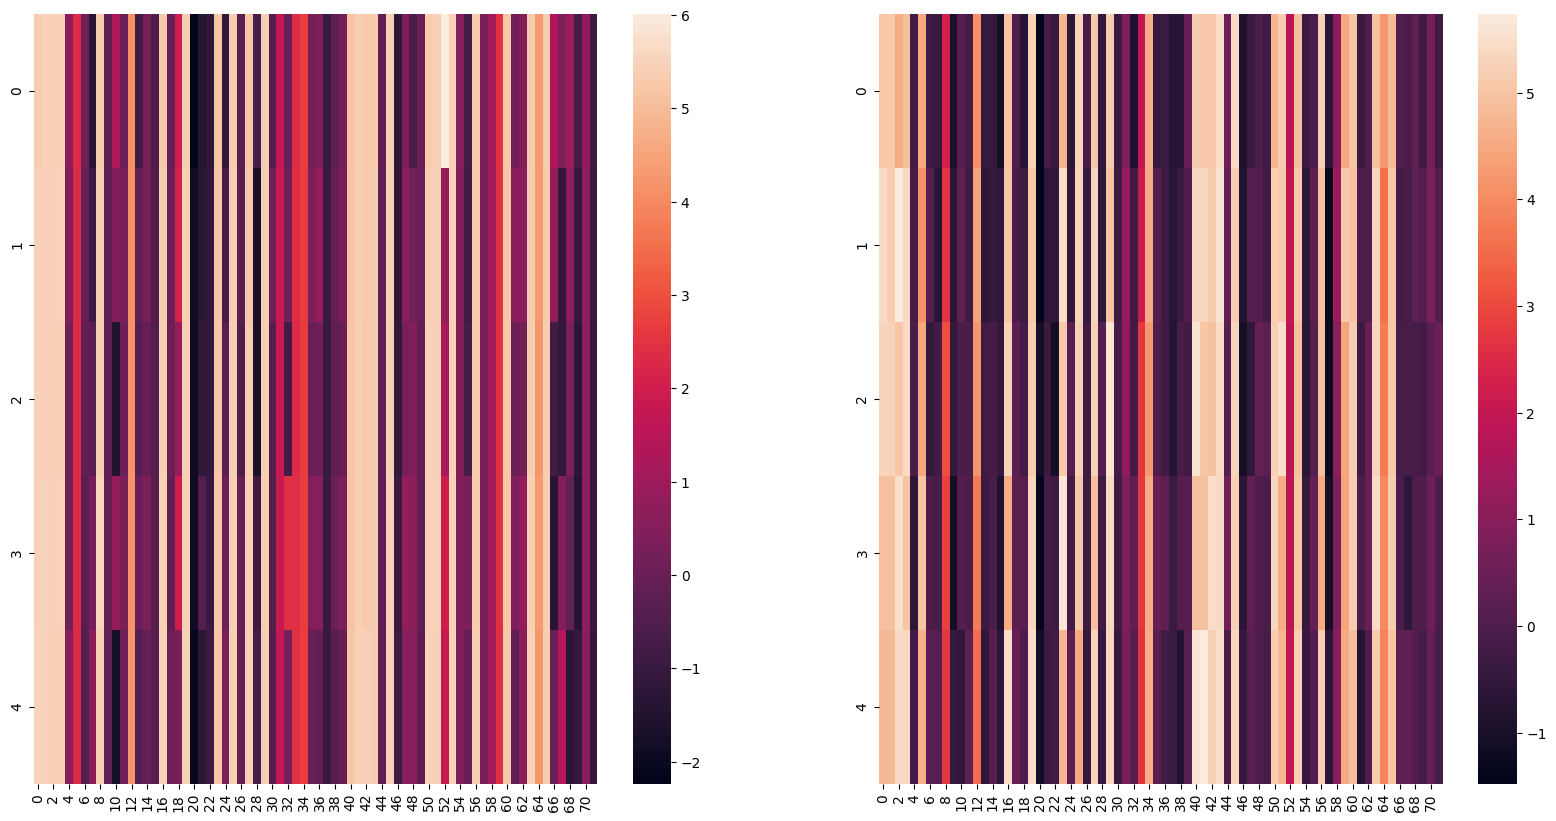

In [158]:
# run model on random data point from test dataset
model.eval()
with torch.no_grad():
    data = next(iter(test_loader))[0].reshape(1, 5, 72)
    output = model(data)

# get loss for the data point
loss = criterion(output, data)
print(f'Loss: {loss}')

data = data.reshape(5, 72)
output = output.reshape(5, 72)
import seaborn as sns
# plot the data and the output as a heatmap
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(data, ax=ax[0])
sns.heatmap(output, ax=ax[1])
plt.show()


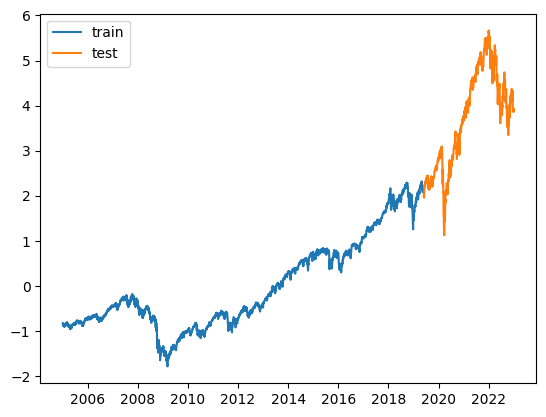

In [171]:
# plot open and close prices from the train and test datasets
plt.plot(sp500_df_train['open'], label='train')
plt.plot(sp500_df_test['open'], label='test')
plt.legend()
plt.show()